# Telco Churn Analysis Notebook

## Preparing the dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("telco_churn.csv")

# Make sure churn is binary numeric (1 = churned, 0 = stayed)
df['Churn'] = df['Churn'].astype(int)

# Create Tenure Group
def tenure_group(tenure):
    if tenure <= 6:
        return "0-6 months"
    elif tenure <= 12:
        return "7-12 months"
    elif tenure <= 24:
        return "13-24 months"
    else:
        return "25+ months"

df['Tenure Group'] = df['Tenure in Months'].apply(tenure_group)

# Create Satisfaction Group
def satisfaction_group(score):
    if score <= 2:
        return "Low"
    elif score <= 4:
        return "Medium"
    else:
        return "High"

df['Satisfaction Group'] = df['Satisfaction Score'].apply(satisfaction_group)


## Exploratory Analysis: Churn Rate Heatmaps

We first visualize churn across key dimensions (e.g., contract type, tenure, payment method, satisfaction) to identify broad patterns and potential risk groups.

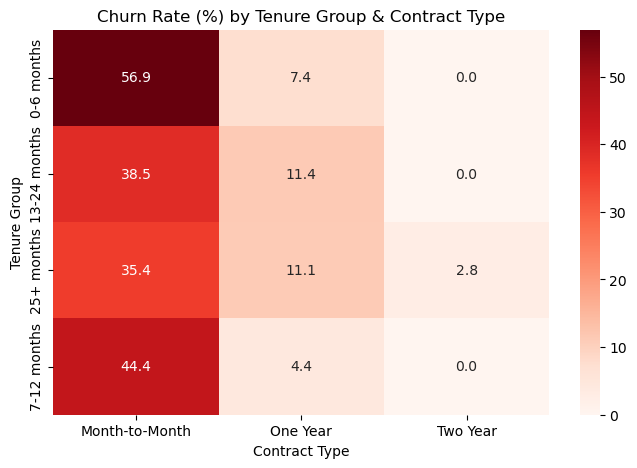

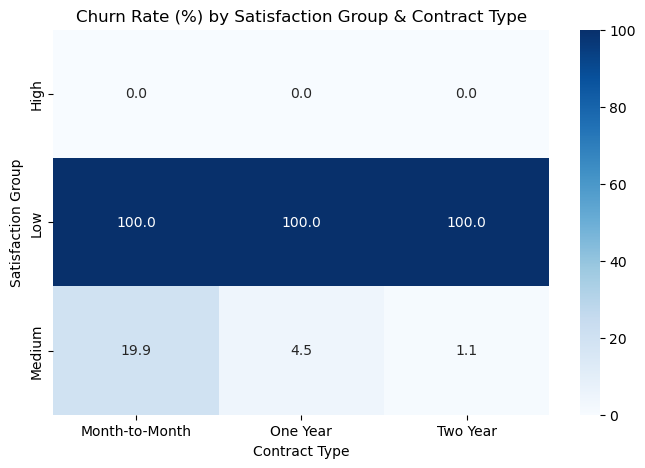

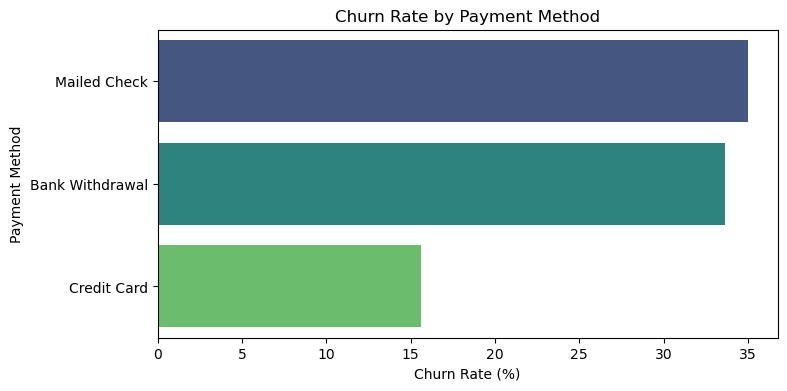

In [2]:
# Churn by Contract × Tenure
pivot1 = df.pivot_table(
    index='Tenure Group',
    columns='Contract',
    values='Churn',
    aggfunc='mean'
) * 100

plt.figure(figsize=(8,5))
sns.heatmap(pivot1, annot=True, fmt=".1f", cmap="Reds")
plt.title("Churn Rate (%) by Tenure Group & Contract Type")
plt.ylabel("Tenure Group")
plt.xlabel("Contract Type")
plt.show()

# Churn by Contract × Satisfaction
pivot2 = df.pivot_table(
    index='Satisfaction Group',
    columns='Contract',
    values='Churn',
    aggfunc='mean'
) * 100

plt.figure(figsize=(8,5))
sns.heatmap(pivot2, annot=True, fmt=".1f", cmap="Blues")
plt.title("Churn Rate (%) by Satisfaction Group & Contract Type")
plt.ylabel("Satisfaction Group")
plt.xlabel("Contract Type")
plt.show()

# Churn by Payment Method × Churn
pivot3 = df.groupby('Payment Method')['Churn'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(8,4))
sns.barplot(x=pivot3.values, y=pivot3.index, palette="viridis")
plt.xlabel("Churn Rate (%)")
plt.ylabel("Payment Method")
plt.title("Churn Rate by Payment Method")
plt.show()


## High-Value Churn Check

We examine churn among customers with high lifetime value or higher monthly charges. Losing these customers has a disproportionate business impact.

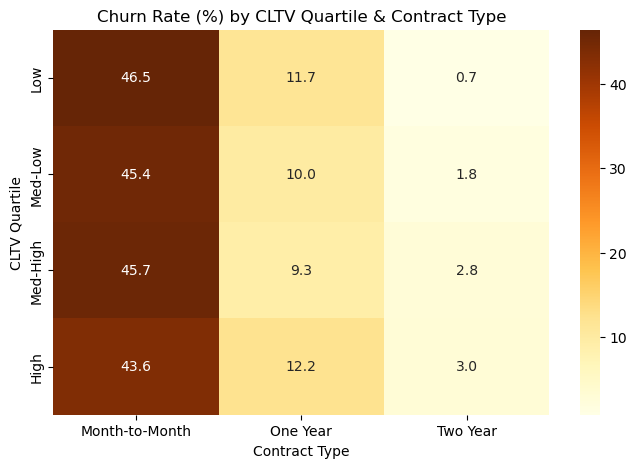

In [3]:
# Segment customers into quartiles based on CLTV
df['CLTV Quartile'] = pd.qcut(df['CLTV'], 4, labels=['Low', 'Med-Low', 'Med-High', 'High'])

pivot4 = df.pivot_table(
    index='CLTV Quartile',
    columns='Contract',
    values='Churn',
    aggfunc='mean'
) * 100

plt.figure(figsize=(8,5))
sns.heatmap(pivot4, annot=True, fmt=".1f", cmap="YlOrBr")
plt.title("Churn Rate (%) by CLTV Quartile & Contract Type")
plt.ylabel("CLTV Quartile")
plt.xlabel("Contract Type")
plt.show()


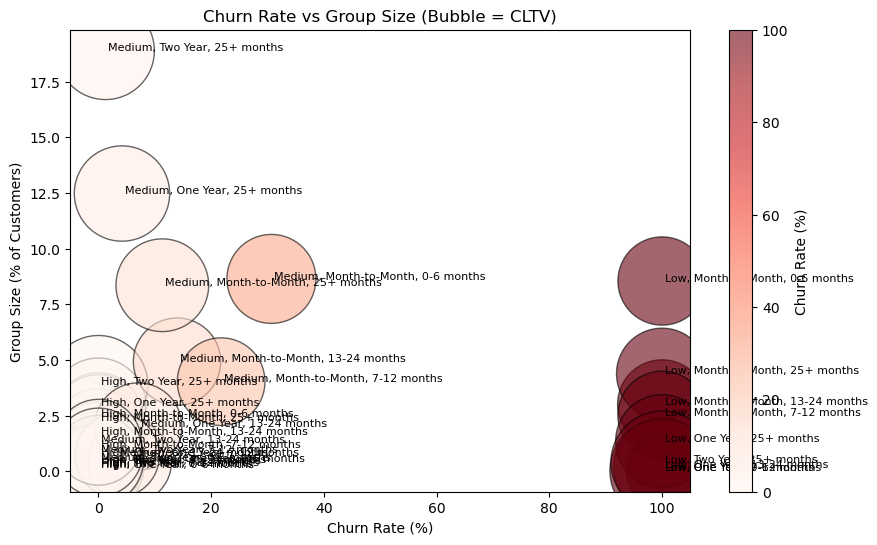

In [4]:
import matplotlib.pyplot as plt

# Group by satisfaction, contract, and tenure
group_summary = df.groupby(['Satisfaction Group', 'Contract', 'Tenure Group']).agg(
    churn_rate=('Churn', 'mean'),
    count=('Customer ID', 'count'),
    avg_cltv=('CLTV', 'mean')
).reset_index()

# Convert churn rate to %
group_summary['churn_rate'] = group_summary['churn_rate'] * 100

# Add proportion of total
total_customers = len(df)
group_summary['proportion'] = group_summary['count'] / total_customers * 100

# Plot bubble chart
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    group_summary['churn_rate'], 
    group_summary['proportion'],
    s=group_summary['avg_cltv'],  # bubble size
    alpha=0.6,
    c=group_summary['churn_rate'], 
    cmap='Reds',
    edgecolor='k'
)

# Label points
for i, row in group_summary.iterrows():
    label = f"{row['Satisfaction Group']}, {row['Contract']}, {row['Tenure Group']}"
    plt.text(row['churn_rate']+0.5, row['proportion'], label, fontsize=8)

plt.xlabel("Churn Rate (%)")
plt.ylabel("Group Size (% of Customers)")
plt.title("Churn Rate vs Group Size (Bubble = CLTV)")
plt.colorbar(scatter, label="Churn Rate (%)")
plt.show()


### Key Observations from Initial Exploration:

1. Customers with shorter tenure and month-to-month contracts churn significantly more.

2. Customers reporting very low satisfaction scores are at near-100% risk of churn.

3. Payment method matters: mailed check users churn more often than credit card or bank withdrawal users, likely due to late fees and manual payment effort.

4. Tenure is a stronger predictor of churn than CLTV at this stage and it can differentiate churn rates better.

-------------------------

### Discover why people with short tenure & month-to-month contract…

Why Do New Customers Leave So Quickly? (When analyzing churn, it’s important not just to measure but to ask “why.”)

1. For short-tenure, month-to-month customers, high prices or poor service quality likely drive dissatisfaction.

2. Dissatisfied customers decide not to continue after their initial experience.

We now dive into specific features one by one.

In [5]:
tg = df[(df["Contract"] == "Month-to-Month") & (df["Tenure in Months"] <= 6)].copy()
tg["bundle_count"] = tg[[
    "Online Backup","Online Security","Device Protection Plan",
    "Streaming TV","Streaming Music","Streaming Movies","Multiple Lines"
]].apply(lambda r: sum((v == 1) for v in r), axis=1)

tg["overage_flag"] = (tg["Total Extra Data Charges"].fillna(0) > 0).astype(int)

#### Top churn reasons

,Churn Reason,Count,Cum%
0,Competitor had better devices,84,17.758985
1,Competitor made better offer,82,35.095137
2,Attitude of support person,52,46.088795
3,Attitude of service provider,37,53.911205
4,Don't know,36,61.522199
5,Competitor offered higher download speeds,23,66.384778
6,Long distance charges,21,70.824524
7,Network reliability,19,74.841438
8,Price too high,17,78.435518
9,Service dissatisfaction,16,81.818182


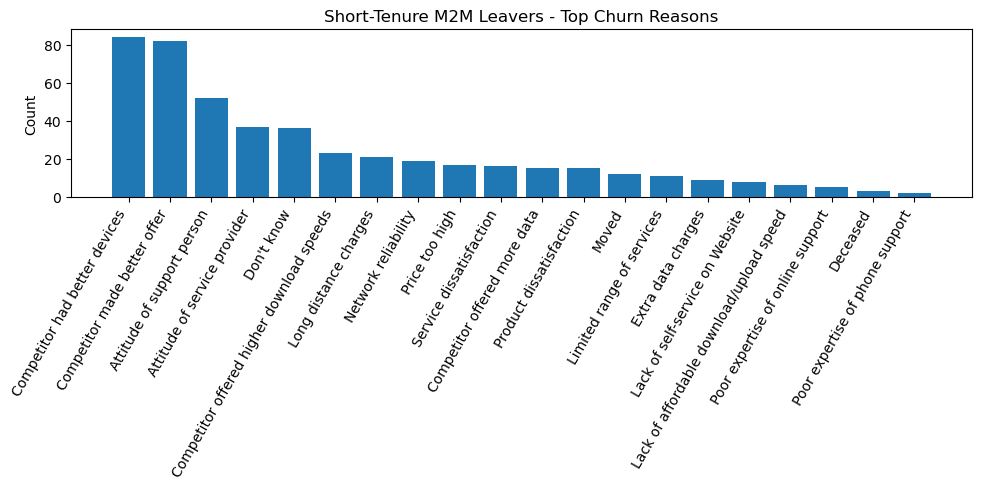

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

leavers = tg[tg["Churn"]==1]

reason_counts = (leavers["Churn Reason"]
                 .fillna("Unknown")
                 .value_counts()
                 .rename_axis("Churn Reason")
                 .reset_index(name="Count"))
reason_counts["Cum%"] = reason_counts["Count"].cumsum()/reason_counts["Count"].sum()*100

display(reason_counts.head(15))

# Pareto plot (bar of counts)
plt.figure(figsize=(10,5))
plt.bar(reason_counts["Churn Reason"], reason_counts["Count"])
plt.xticks(rotation=60, ha='right')
plt.ylabel("Count")
plt.title("Short-Tenure M2M Leavers - Top Churn Reasons")
plt.tight_layout()
plt.show()


Customers most frequently cited better devices and offers from competitors as their top churn reasons. This highlights competitive pressure in retention.

#### “Unique to this segment” reasons (lift vs overall)

In [7]:
overall = df[df["Churn"]==1]["Churn Reason"].fillna("Unknown").value_counts(normalize=True)
seg = leavers["Churn Reason"].fillna("Unknown").value_counts(normalize=True)
lift = (seg - overall).rename("Lift_vs_Overall").reset_index().rename(columns={"index":"Churn Reason"})
lift = lift.sort_values("Lift_vs_Overall", ascending=False)
display(lift.head(15))

,Churn Reason,Lift_vs_Overall
0,Attitude of service provider,0.021132
2,Competitor had better devices,0.009882
12,Long distance charges,0.009607
3,Competitor made better offer,0.006546
19,Service dissatisfaction,0.005281
10,Lack of self-service on Website,0.001748
6,Deceased,0.000990
11,Limited range of services,0.000954
16,Poor expertise of phone support,0.000660
4,Competitor offered higher download speeds,0.000455


We compare churn reasons for this subgroup versus the overall customer base, highlighting issues disproportionately affecting them.

Onboarding & value realization

In [8]:
summary_onboarding = tg.groupby("Churn").agg(
    satisfaction_mean=("Satisfaction Score","mean"),
    monthly_charge=("Monthly Charge","mean"),
    bundle_mean=("bundle_count","mean"),
    tech_support_rate=("Premium Tech Support", "mean")
).rename(index={0:"Stayers",1:"Leavers"})
display(summary_onboarding)

,satisfaction_mean,monthly_charge,bundle_mean,tech_support_rate
Churn,,,,
Stayers,3.932961,44.191899,0.815642,0.122905
Leavers,1.778013,64.039112,1.429175,0.082452


Summary:

1. Churn is often linked to whether customers quickly realize value from their subscription. 

2. Poor onboarding, unclear service benefits, or unmet expectations can accelerate churn.

3. Churners often hold multiple add-on services (online backup, device protection, streaming), which increases monthly charges. 

4. Yet, these customers report lower satisfaction—suggesting they pay more but feel undersupported (e.g., limited tech support).

#### Bill-shock & friction

In [9]:
summary_billing = tg.groupby("Churn").agg(
    monthly_charge=("Monthly Charge","mean"),
    unlimited_share=("Unlimited Data", "mean"),
    mailcheck_share=("Payment Method", lambda s: (s.astype(str).str.contains("Mailed Check", case=False, na=False)).mean()),
    paperless_share=("Paperless Billing", "mean"),
    age=('Age', 'mean')
).rename(index={0:"Stayers",1:"Leavers"})
display(summary_billing)


,monthly_charge,unlimited_share,mailcheck_share,paperless_share,age
Churn,,,,,
Stayers,44.191899,0.500000,0.089385,0.463687,40.918994
Leavers,64.039112,0.811839,0.109937,0.712474,47.300211


#### Older customers & paperless billing

1. Older customers with higher monthly charges are more likely to churn when using paperless billing.

2. They may be less accustomed to e-bills, leading to “bill shock” when large charges are auto-withdrawn without prior review.

3. Lack of transparent reminders can exacerbate dissatisfaction and churn.

### Next Step: Focus on Paperless Billing

Given its strong predictive power, we further analyze paperless billing in interaction with other factors to understand which customers are most at risk.

#### Separate paperless from different payment method

In [10]:
tg = df[(df["Contract"]=="Month-to-Month") & (df["Tenure in Months"]<=6)].copy()

paperless_pm = (tg.groupby(["Paperless Billing"])["Churn"]
                  .mean()*100).round(2).reset_index()
paperless_pm

,Paperless Billing,Churn
0,0,41.46
1,1,67.00


In [11]:
tg = df[(df["Contract"]=="Month-to-Month") & (df["Tenure in Months"]<=6)].copy()

import numpy as np
pm = tg["Payment Method"].str.lower()

tg["paytype"] = np.select(
    [
        pm.str.contains("credit card", na=False),
        pm.str.contains("bank|withdrawal|direct debit|ach", na=False),
        pm.str.contains("mailed check", na=False),
    ],
    ["Credit Card","Bank Withdrawal","Mailed Check"],
    default="Other"
)
tg["autopay"] = tg["paytype"].isin(["Credit Card","Bank Withdrawal"]).astype(int)

# churn by Paperless vs Paytype
paperless_paytype = (tg.groupby(["Paperless Billing","paytype"])["Churn"]
                  .mean()*100).round(2).reset_index()
paperless_paytype.sort_values(["Paperless Billing","Churn"], ascending=[True,False], inplace=True)
paperless_paytype


,Paperless Billing,paytype,Churn
2,0,Mailed Check,53.66
0,0,Bank Withdrawal,53.38
1,0,Credit Card,27.92
3,1,Bank Withdrawal,76.83
5,1,Mailed Check,69.77
4,1,Credit Card,41.67


#### Age interaction: does paperless hurt only for certain ages?

In [12]:
tg["age_band"] = pd.cut(tg["Age"], [0,29,44,59,120], labels=["<30","30-44","45-59","60+"])

age_paperless = (tg.groupby(["age_band","Paperless Billing"])["Churn"]
                   .mean().unstack()*100).round(1)
age_paperless


Paperless Billing,0,1
age_band,,
<30,43.8,56.6
30-44,31.9,65.2
45-59,44.4,60.9
60+,55.6,84.0


#### Bill charge and satisfaction score inside paperless vs non-paperless

We compare satisfaction scores and average monthly charges for customers under each billing type, to see if higher dissatisfaction is uniquely linked to paperless.

In [13]:
cols = ["Monthly Charge","Total Extra Data Charges","Total Long Distance Charges","Satisfaction Score"]
bill_cmp = tg.groupby("Paperless Billing")[cols].mean().round(2)
bill_cmp

,Monthly Charge,Total Extra Data Charges,Total Long Distance Charges,Satisfaction Score
Paperless Billing,,,,
0,44.05,1.80,54.91,3.03
1,62.95,2.27,58.46,2.50


Combine paperless billing, payment method, satisfaction score, age and monthly charge factors.

In [14]:
tg = df[(df["Contract"]=="Month-to-Month") & (df["Tenure in Months"]<=6)].copy()
tg = tg[tg["Tenure in Months"]>0].copy()

tg["extra_data_per_mo"] = tg["Total Extra Data Charges"].fillna(0) / tg["Tenure in Months"]
tg["ld_per_mo"]         = tg["Total Long Distance Charges"].fillna(0) / tg["Tenure in Months"]

summary = (tg.groupby(["Paperless Billing","Payment Method"])
             .agg(churn_rate=("Churn","mean"),
                  n=("Customer ID","count"),
                  satisfaction_score=("Satisfaction Score","mean"),
                  age=("Age","mean"),
                  monthly=("Monthly Charge","mean"),)
             .reset_index())
summary["churn_%"] = (summary["churn_rate"]*100).round(1)
summary

,Paperless Billing,Payment Method,churn_rate,n,satisfaction_score,age,monthly,churn_%
0,0,Bank Withdrawal,0.533835,133,2.729323,43.857143,57.073308,53.4
1,0,Credit Card,0.279221,154,3.357143,40.233766,35.318182,27.9
2,0,Mailed Check,0.536585,41,2.780488,41.609756,34.597561,53.7
3,1,Bank Withdrawal,0.768293,328,2.298780,47.817073,68.509299,76.8
4,1,Credit Card,0.416667,132,3.022727,42.939394,53.931818,41.7
5,1,Mailed Check,0.697674,43,2.372093,45.000000,48.206977,69.8


#### Paperless vs Non-Paperless: Key Findings

Older customers who opt for paperless billing also face higher monthly charges.

Paperless + Bank Withdrawal customers churn more than mailed check users, despite checks being more manual.

Hypothesis: mailed check users physically see their bill before paying, while bank withdrawal customers may experience unexpected deductions, driving frustration and churn.

## Validation & Actions & Insights

Based on the validation process, we synthesize findings into concrete recommendations.

In [17]:
import numpy as np, pandas as pd, statsmodels.api as sm

tg = tg.copy()

# Target must be numeric
y = tg["Churn"].astype(int)

# Ensure Paperless is 0/1 numeric (handles Yes/No or 0/1)
if tg["Paperless Billing"].dtype == "O":
    tg["Paperless Billing"] = tg["Paperless Billing"].str.strip().str.lower().map({"yes":1,"no":0})
tg["Paperless Billing"] = pd.to_numeric(tg["Paperless Billing"], errors="coerce")

# Derive per-month charges if you use them
tg["extra_data_per_mo"] = tg["Total Extra Data Charges"].fillna(0) / tg["Tenure in Months"].replace(0, np.nan)
tg["ld_per_mo"] = tg["Total Long Distance Charges"].fillna(0) / tg["Tenure in Months"].replace(0, np.nan)

tg["Payment Method"] = tg["Payment Method"].replace({
    'Credit Card': 'AAA_Credit Card'  # Force it to be first alphabetically
})

# One-hot encode categorical with numeric dtype
X_cat = pd.get_dummies(tg[["Payment Method"]], drop_first=True, dtype=float)

# Continuous features (force numeric)
X_cont = tg[["Paperless Billing","Monthly Charge","Satisfaction Score","Age","extra_data_per_mo","ld_per_mo"]].apply(
    pd.to_numeric, errors="coerce"
)

# Combine
X = pd.concat([X_cat, X_cont], axis=1)

# Drop rows with NA / inf that statsmodels can’t handle
Xy = pd.concat([X, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
y = Xy["Churn"].astype(int)
X = Xy.drop(columns=["Churn"])

# Fit
X = sm.add_constant(X)
model = sm.Logit(y, X).fit(disp=False)
print(model.summary())


                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                  831
Model:                          Logit   Df Residuals:                      822
Method:                           MLE   Df Model:                            8
Date:                Fri, 22 Aug 2025   Pseudo R-squ.:                  0.7565
Time:                        23:25:20   Log-Likelihood:                -138.29
converged:                      False   LL-Null:                       -568.02
Covariance Type:            nonrobust   LLR p-value:                3.108e-180
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             49.7832   1250.718      0.040      0.968   -2401.578    2501.144
Payment Method_Bank Withdrawal     0.7893      0.351      2.246      0.

/Users/jessica/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Interpretation

1. Bank Withdrawal vs Credit Card (Coefficient: 0.7893)

* Interpretation: Bank Withdrawal customers have exp(0.7893) = 2.20 times higher odds of churning compared to Credit Card customers
* Or: Bank Withdrawal increases churn odds by (2.20 - 1) × 100% = 120% compared to Credit Card

2. Mailed Check vs Credit Card (Coefficient: 0.9350)

* Interpretation: Mailed Check customers have exp(0.9350) = 2.55 times higher odds of churning compared to Credit Card customers
* Or: Mailed Check increases churn odds by (2.55 - 1) × 100% = 155% compared to Credit Card

Other Significant Factors (p < 0.05):

1. Paperless Billing (p = 0.022 & Coefficient: 0.7325)

* Interpretation: Customers with paperless billing have exp(0.7325) = 2.08 times higher odds of churning compared to those without paperless billing

2. Monthly Charge (p = 0.001 & Coefficient: 0.0213)

* Interpretation: For each $1 increase in monthly charge, the odds of churning increase by exp(0.0213) = 1.022 times (or 2.2% increase)
* Practical example: A $10 increase in monthly charge increases churn odds by exp(0.0213 × 10) = 1.24 times

3. Age (p = 0.001 & Coefficient: 0.0221):

* Interpretation: For each additional year of age, the odds of churning increase by exp(0.0221) = 1.022 times (or 2.2% increase)

### Insights & Action

Odds ratio (OR) quick ref: OR = e^β. OR>1 increases churn odds; OR<1 decreases them. β is coef in the output above.

Paperless itself is an at-risk experience: even after controls, paperless users are ~2× more likely to churn → fix first-bill comprehension, send bill forecasts, and add pre-withdrawal “review & pause” step.

Push credit-card autopay within this cohort: substantially lower churn than bank withdrawal.

Price management matters: +£/$10 ≈ +24% higher odds → target price-sensitive paperless newbies with caps/first-month unlimited.

Older paperless newbies need extra onboarding.

## Future Work

Using data to find the gap in data is a very subjective process which means you can analyse your data from different angles. There is no wrong or correct approach for it. It is very important to ask why and so what for what you see from the data. Then, dig into the reasons behind it. Make it like a real business work!

Moreover, in the real business, we usually need to check the time consistency and stability of the hypothesis to get more confidence.

## Final reflection

Churn analysis is not just about statistical models—it requires continuous “why” questions to uncover behavioral and experiential drivers. Business context and customer perspective are critical for turning insights into actionable retention strategies.